In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
from imblearn.over_sampling import SMOTE

In [2]:
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# pip install matplotlib
# pip install scikit-learn
# pip install imbalanced-learn

# Tratamento dos dados

In [3]:
df = pd.read_csv("data/results/time_data.csv", sep=";")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12960 entries, 0 to 12959
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         12960 non-null  object 
 1   812A         12960 non-null  float64
 2   833A         12960 non-null  float64
 3   812A_tweets  12960 non-null  float64
 4   833A_tweets  12960 non-null  float64
 5   812A_flood   12960 non-null  int64  
 6   833A_flood   12960 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 708.9+ KB


In [5]:
df["time"] = pd.to_datetime(df["time"])

C:\Users\Jefferson\AppData\Local\Temp\ipykernel_8516\2530938752.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df["time"] = pd.to_datetime(df["time"])


In [6]:
df = df.drop(["812A_tweets", "833A_tweets"], axis=1)

In [7]:
def plot_rain_gauge(df):
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    columns = ["812A", "833A"]

    for i, col in enumerate(columns):
        axs[i].plot(df["time"], df[col], label=col, color=f"C{i}")
        axs[i].set_title(f"Série Temporal: {col}")
        axs[i].set_ylabel("Valor")
        axs[i].legend()

    axs[-1].set_xlabel("Data")

    plt.tight_layout()
    plt.show()

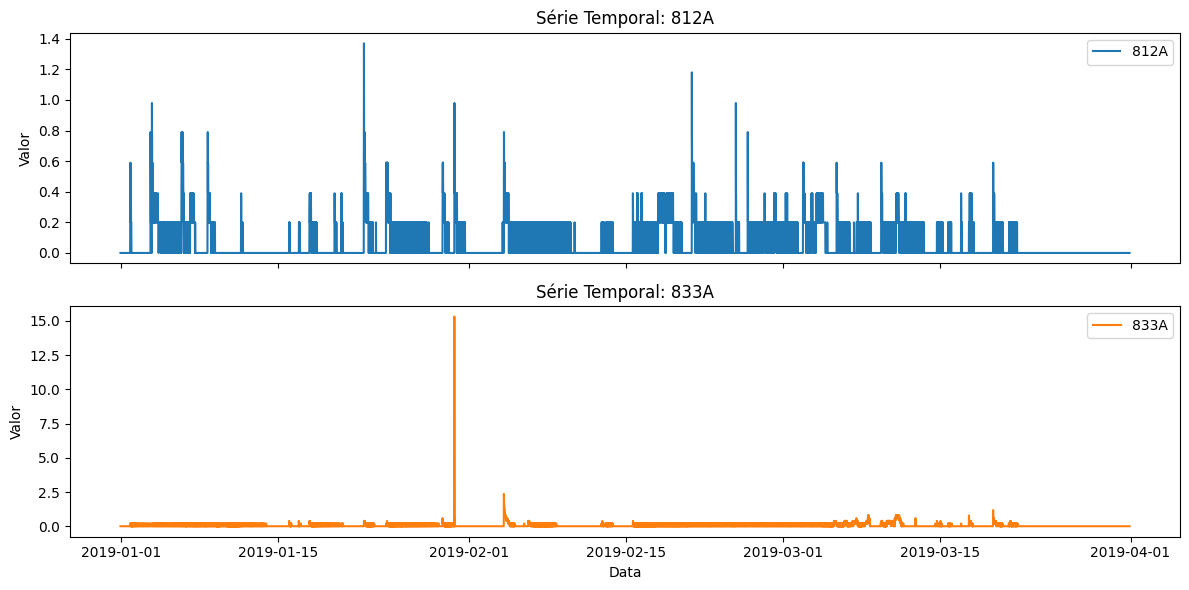

In [8]:
plot_rain_gauge(df)

In [9]:
df['833A'] = df['833A'].apply(lambda x: 2.5 if x > 2.5 else x)

In [10]:
df["flood"] = 0

In [11]:
df.loc[((df["812A_flood"] == 1) | (df["833A_flood"] == 1)), "flood"] = 1

In [12]:
X = df[["812A", "833A"]]
y = df["flood"]

# Treinamento do modelo

In [13]:
def create_time_windows_with_offset(df, feature_cols, target_col, window_size, offset):
    X, y = [], []
    for i in range(len(df) - window_size - offset + 1):
        X.append(df[feature_cols].iloc[i:i + window_size].values)
        y.append(df[target_col].iloc[i + window_size + offset - 1])
    return np.array(X), np.array(y)

In [14]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [15]:
def split_and_oversample(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_reshaped, y_train)

    input_window_size = X_train.shape[1]
    input_feature_size = X_train.shape[2]
    X_train_balanced = X_train_balanced.reshape(-1, input_window_size, input_feature_size)

    return X_train_balanced, X_test, y_train_balanced, y_test

In [16]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).flatten()
        predictions = (predictions > 0.5).int()

    y_test_np = y_test.numpy()
    predictions_np = predictions.numpy()

    cm = confusion_matrix(y_test_np, predictions_np)
    return cm

In [17]:
def create_model(X_train):
    input_size = X_train.shape[1] * X_train.shape[2]  # Janelas * Features
    hidden_size = 64
    output_size = 1

    model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

    return model

In [18]:
def train_model(model, X_train, y_train):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    epochs = 50
    batch_size = 32

    for _ in range(epochs):
        model.train()
        running_loss = 0.0
        
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.flatten(), y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

In [19]:
def train_and_evaluate_mlp(df, feature_cols, target_col, window_size, offset):
    print(f"\n=== Window_size = {window_size}, offset = {offset} ===")
    X, y = create_time_windows_with_offset(df, feature_cols, target_col, window_size, offset)

    X_train, X_test, y_train, y_test = split_and_oversample(X, y)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    model = create_model(X_train)
    train_model(model, X_train_tensor, y_train_tensor)
    cm = evaluate_model(model, X_test_tensor, y_test_tensor)

    print(cm)

In [20]:
feature_cols = ["833A", "812A"]
target_col = "flood"

offset = 1
for i in [1, 3, 6]:
         train_and_evaluate_mlp(df, feature_cols, target_col, i, offset)


=== Window_size = 1, offset = 1 ===
[[   0 2486]
 [   0  106]]

=== Window_size = 3, offset = 1 ===
[[1346 1149]
 [   2   95]]

=== Window_size = 6, offset = 1 ===
[[1322 1164]
 [   1  104]]


In [21]:
offset = 3
for i in [1, 3, 6]:
         train_and_evaluate_mlp(df, feature_cols, target_col, i, offset)


=== Window_size = 1, offset = 3 ===
[[   0 2495]
 [   0   97]]

=== Window_size = 3, offset = 3 ===
[[1230 1262]
 [   4   95]]

=== Window_size = 6, offset = 3 ===
[[  69 2423]
 [   0   99]]


In [22]:
offset = 6
for i in [1, 3, 6]:
         train_and_evaluate_mlp(df, feature_cols, target_col, i, offset)


=== Window_size = 1, offset = 6 ===
[[   0 2486]
 [   0  105]]

=== Window_size = 3, offset = 6 ===
[[   0 2492]
 [   0   99]]

=== Window_size = 6, offset = 6 ===
[[   3 2472]
 [   0  115]]


# LSTM

## Setup

In [23]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return torch.sigmoid(out)

In [24]:
def train_and_evaluate_model(df, feature_cols, target_col, time_windows, params):
    window_size = time_windows['window_size']
    offset = time_windows['offset']

    layers = params['layers']
    neurons = params['neurons']

    print(f"\n=== Testando com offset = {offset} ===")
    
    X, y = create_time_windows_with_offset(df, feature_cols, target_col, window_size, offset)
    
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    y = y.astype(int)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    smote = SMOTE(random_state=42)
    X_train_flat_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train)
    X_train_resampled = X_train_flat_resampled.reshape(-1, X_train.shape[1], X_train.shape[2])
    
    X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    
    model = LSTMModel(input_size=X_train.shape[2], hidden_size=neurons, output_size=1, num_layers=layers)
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for _ in range(50):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor).squeeze()
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).squeeze()
        predictions_binary = (predictions >= 0.5).int()
        
        y_test_binary = y_test_tensor.int()
        conf_matrix = confusion_matrix(y_test_binary, predictions_binary)
        print("Confusion Matrix:")
        print(conf_matrix)

In [25]:
FEATURE_COLS = ["833A", "812A"]
TARGET_COL = "flood"

## Camadas: 1

In [26]:
LAYERS = 1
WINDOW_SIZE = 6

### Neurônios: 32

In [27]:
model_parameters = {"layers": LAYERS, "neurons": 32}

for offset in [1, 3, 6]:
    time_windows = {"window_size": WINDOW_SIZE, "offset": offset}
    train_and_evaluate_model(df, FEATURE_COLS, TARGET_COL, time_windows, model_parameters)


=== Testando com offset = 1 ===
Confusion Matrix:
[[1982  504]
 [  37   68]]

=== Testando com offset = 3 ===
Confusion Matrix:
[[2308  184]
 [  51   48]]

=== Testando com offset = 6 ===
Confusion Matrix:
[[1867  608]
 [  39   76]]


### Neurônios: 64

In [28]:
model_parameters = {"layers": LAYERS, "neurons": 64}

for offset in [1, 3, 6]:
    time_windows = {"window_size": WINDOW_SIZE, "offset": offset}
    train_and_evaluate_model(df, FEATURE_COLS, TARGET_COL, time_windows, model_parameters)


=== Testando com offset = 1 ===
Confusion Matrix:
[[2055  431]
 [  40   65]]

=== Testando com offset = 3 ===
Confusion Matrix:
[[2017  475]
 [  37   62]]

=== Testando com offset = 6 ===
Confusion Matrix:
[[2001  474]
 [  51   64]]


### Neurônios: 128

In [29]:
model_parameters = {"layers": LAYERS, "neurons": 128}

for offset in [1, 3, 6]:
    time_windows = {"window_size": WINDOW_SIZE, "offset": offset}
    train_and_evaluate_model(df, FEATURE_COLS, TARGET_COL, time_windows, model_parameters)


=== Testando com offset = 1 ===
Confusion Matrix:
[[1824  662]
 [  23   82]]

=== Testando com offset = 3 ===
Confusion Matrix:
[[1912  580]
 [  30   69]]

=== Testando com offset = 6 ===
Confusion Matrix:
[[1952  523]
 [  47   68]]


## Camadas: 2

In [31]:
LAYERS = 2
WINDOW_SIZE = 6

### Neurônios: 32

In [32]:
model_parameters = {"layers": LAYERS, "neurons": 32}

for offset in [1, 3, 6]:
    time_windows = {"window_size": WINDOW_SIZE, "offset": offset}
    train_and_evaluate_model(df, FEATURE_COLS, TARGET_COL, time_windows, model_parameters)


=== Testando com offset = 1 ===
Confusion Matrix:
[[2093  393]
 [  46   59]]

=== Testando com offset = 3 ===
Confusion Matrix:
[[   0 2492]
 [   0   99]]

=== Testando com offset = 6 ===
Confusion Matrix:
[[2071  404]
 [  58   57]]


### Neurônios: 64

In [33]:
model_parameters = {"layers": LAYERS, "neurons": 64}

for offset in [1, 3, 6]:
    time_windows = {"window_size": WINDOW_SIZE, "offset": offset}
    train_and_evaluate_model(df, FEATURE_COLS, TARGET_COL, time_windows, model_parameters)


=== Testando com offset = 1 ===
Confusion Matrix:
[[1734  752]
 [  19   86]]

=== Testando com offset = 3 ===
Confusion Matrix:
[[1782  710]
 [  26   73]]

=== Testando com offset = 6 ===
Confusion Matrix:
[[1773  702]
 [  33   82]]


### Neurônios: 128

In [34]:
model_parameters = {"layers": LAYERS, "neurons": 128}

for offset in [1, 3, 6]:
    time_windows = {"window_size": WINDOW_SIZE, "offset": offset}
    train_and_evaluate_model(df, FEATURE_COLS, TARGET_COL, time_windows, model_parameters)


=== Testando com offset = 1 ===
Confusion Matrix:
[[1836  650]
 [  24   81]]

=== Testando com offset = 3 ===
Confusion Matrix:
[[1812  680]
 [  26   73]]

=== Testando com offset = 6 ===
Confusion Matrix:
[[1774  701]
 [  37   78]]
